# EconML API Notebook

This notebook demonstrates the **native EconML programming interface** using a small **synthetic dataset**.

**Scope (per instructor guidance):**
- This notebook is **not connected to the project dataset (NHANES)**.
- It only explains **EconML as a tool** and shows how to use its core objects.
- Project-specific analysis and results belong in: `econml.example.ipynb` and `econml.example.md`.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor

from econml.dr import DRLearner

print("numpy:", np.__version__)
print("pandas:", pd.__version__)
print("sklearn:", sklearn.__version__)

import econml
print("econml:", econml.__version__)

%matplotlib inline


numpy: 1.24.4
pandas: 2.0.3
sklearn: 1.3.2
econml: 0.15.1


## 1) Create a synthetic causal dataset

We simulate data with:
- `X`: covariates
- `T`: binary treatment assigned with confounding (depends on `X`)
- `Y`: outcome generated with a **heterogeneous treatment effect** `tau(X)`

This lets us validate whether EconML can recover:
- ATE (average treatment effect)
- CATE (individual / conditional treatment effects)


In [2]:
def make_synthetic_data(n=2000, p=5, seed=42):
    rng = np.random.default_rng(seed)

    X = rng.normal(size=(n, p))

    # True heterogeneous treatment effect (depends on X)
    tau = 2.0 + 1.5 * X[:, 0] - 1.0 * (X[:, 1] ** 2)

    # Confounded treatment assignment: P(T=1|X) depends on X
    logits = 0.5 * X[:, 0] - 0.7 * X[:, 1] + 0.3 * X[:, 2]
    prop = 1 / (1 + np.exp(-logits))
    T = rng.binomial(1, prop)

    # Outcome model with confounding + treatment effect
    base = 1.0 + 0.8 * X[:, 0] + 0.5 * X[:, 1] - 0.3 * X[:, 2]
    noise = rng.normal(scale=1.0, size=n)
    Y = base + tau * T + noise

    return Y, T, X, tau

Y, T, X, tau_true = make_synthetic_data(n=2000, p=5, seed=42)

print("Shapes -> Y:", Y.shape, "T:", T.shape, "X:", X.shape)
print("Treatment rate:", T.mean().round(3))
print("True ATE (mean tau):", float(np.mean(tau_true)))


Shapes -> Y: (2000,) T: (2000,) X: (2000, 5)
Treatment rate: 0.5
True ATE (mean tau): 0.8833482581121943


## 2) Native EconML API: `DRLearner`

`DRLearner` is a doubly-robust estimator that combines:
- an **outcome model**  E[Y|T, X]
- a **propensity model** P(T=1|X)

We fit the model and then compute:
- CATE estimates: `model.effect(X)`
- ATE estimate: average of CATEs over a set of X


In [3]:
# Models used inside DRLearner
outcome_model = RandomForestRegressor(n_estimators=200, min_samples_leaf=10, random_state=42)
propensity_model = LogisticRegression(max_iter=2000)

dr = DRLearner(
    model_regression=outcome_model,
    model_propensity=propensity_model
)

dr.fit(Y=Y, T=T, X=X)

tau_hat = dr.effect(X)                  # CATE estimates
ate_hat = float(np.mean(tau_hat))       # ATE estimate (mean CATE)

print("Estimated ATE:", round(ate_hat, 3))
print("True ATE:", round(float(np.mean(tau_true)), 3))

# quick sanity: correlation between true and estimated CATE (should be positive)
corr = np.corrcoef(tau_true, tau_hat)[0, 1]
print("Corr(true CATE, estimated CATE):", round(float(corr), 3))


Estimated ATE: 0.796
True ATE: 0.883
Corr(true CATE, estimated CATE): 0.676


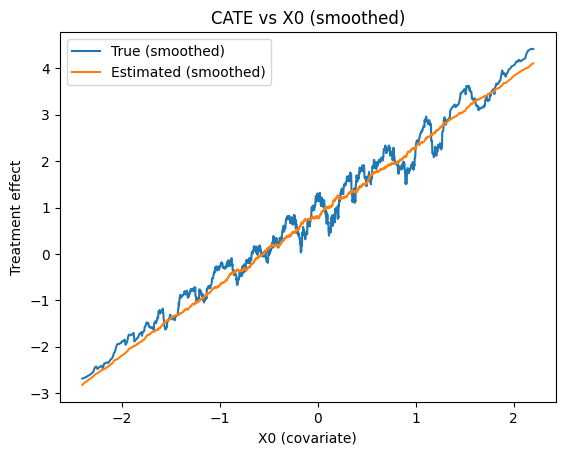

In [4]:
df_plot = pd.DataFrame({
    "x0": X[:, 0],
    "tau_true": tau_true,
    "tau_hat": tau_hat
}).sort_values("x0")

plt.figure()
plt.plot(df_plot["x0"].rolling(50).mean(), df_plot["tau_true"].rolling(50).mean(), label="True (smoothed)")
plt.plot(df_plot["x0"].rolling(50).mean(), df_plot["tau_hat"].rolling(50).mean(), label="Estimated (smoothed)")
plt.xlabel("X0 (covariate)")
plt.ylabel("Treatment effect")
plt.title("CATE vs X0 (smoothed)")
plt.legend()
plt.show()


## 3) Lightweight wrapper layer (tool-focused)

Below is a small wrapper that:
- fits `DRLearner`
- returns a clean dictionary (model + ATE + bootstrap CI + CATEs)

This wrapper is **generic** (it works for any `Y, T, X`), and is shown here only to demonstrate
how one might build a thin layer on top of EconML’s native API.


In [5]:
def fit_drlearner_with_bootstrap_ci(
    Y, T, X,
    n_bootstrap=30,
    seed=42
):
    rng = np.random.default_rng(seed)

    # Fit once on full data
    dr = DRLearner(
        model_regression=RandomForestRegressor(
            n_estimators=200, min_samples_leaf=10, random_state=seed
        ),
        model_propensity=LogisticRegression(max_iter=2000)
    )
    dr.fit(Y=Y, T=T, X=X)
    tau_hat = dr.effect(X)
    ate_hat = float(np.mean(tau_hat))

    # Bootstrap ATE
    n = len(Y)
    boots = []
    for _ in range(n_bootstrap):
        idx = rng.integers(0, n, size=n)
        dr_b = DRLearner(
            model_regression=RandomForestRegressor(
                n_estimators=150, min_samples_leaf=10, random_state=seed
            ),
            model_propensity=LogisticRegression(max_iter=2000)
        )
        dr_b.fit(Y=Y[idx], T=T[idx], X=X[idx])
        boots.append(float(np.mean(dr_b.effect(X))))

    ci_low, ci_high = np.percentile(boots, [2.5, 97.5])

    return {
        "model": dr,
        "ate": ate_hat,
        "ate_ci_low": float(ci_low),
        "ate_ci_high": float(ci_high),
        "cate": tau_hat,
        "n_obs": int(n),
        "n_bootstrap": int(n_bootstrap),
    }

results = fit_drlearner_with_bootstrap_ci(Y, T, X, n_bootstrap=30, seed=42)

print("Wrapper output keys:", results.keys())
print("ATE:", round(results["ate"], 3))
print("ATE 95% bootstrap CI:", (round(results["ate_ci_low"], 3), round(results["ate_ci_high"], 3)))


Wrapper output keys: dict_keys(['model', 'ate', 'ate_ci_low', 'ate_ci_high', 'cate', 'n_obs', 'n_bootstrap'])
ATE: 0.813
ATE 95% bootstrap CI: (0.644, 0.908)


## 4) Minimal reuse pattern

To reuse EconML DRLearner on any dataset, you need:

1. Arrays:
   - `Y` (shape `(n,)`)
   - `T` (shape `(n,)`, binary 0/1)
   - `X` (shape `(n, p)`)

2. Fit:
   - `dr.fit(Y, T, X)`

3. Estimate:
   - `dr.effect(X_new)` for CATE
   - average of those effects for an ATE-style summary
